In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error as mae
mse = nn.MSELoss()
import torch.optim.lr_scheduler as lr_scheduler
device=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import seaborn as sns
x_in = 1
x_dot_in = 0.25
alpha = 100
sigma =1000
from scipy.integrate import solve_ivp
import math
# rnd = np.random.default_rng(0)

Euler Maruyama SDE Solver for Data Generation

In [2]:
def Euler_Maruyama(param,dt,n):
    [p1,p2] = param
    sol = np.zeros(n)
    sol_dot =  np.zeros(n) 
    sol[0] =x_in 
    sol_dot[0] = x_dot_in
    for i in range(n-1):
        sol[i+1] = sol[i] + sol_dot[i]*dt
        sol_dot[i+1] = sol_dot[i] + dt*(-(p1*sol_dot[i]*(1-sol[i]**2)) + p2*sol[i] - alpha*sol[i]**3 + sigma*sol[i]*np.random.randn(1)*np.sqrt(dt))
    return sol,sol_dot

Pure Physics(Incomplete) model using Euler Maruyama solver

In [3]:
def Physics_pure(param,batch_size,dt,n):
    zp = param
    s_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
    s_dash_dot = torch.zeros((batch_size,n),dtype = float).to(device)
    s_dash[:,0] = x_in * torch.ones((batch_size), dtype = float).to(device)
    s_dash_dot[:,0] = x_dot_in * torch.ones((batch_size), dtype = float).to(device)
    dT = 0.001 * torch.ones(batch_size).to(device)
    dW = torch.sqrt(dT)*torch.randn(batch_size).to(device)
    for i in range(n-1):
        s_dash[:,i+1] = s_dash[:,i] + dT*s_dash_dot[:,i]
        s_dash_dot[:,i+1] = s_dash_dot[:,i] + dT*(-(zp[:,0]*s_dash_dot[:,i]) + zp[:,1]*s_dash[:,i] - alpha*s_dash[:,i]**3 + sigma*s_dash[:,i]*dW)
    return s_dash, s_dash_dot 

Data Generation

0.12398212474861024
(3500, 1000)
prm (3500, 2)


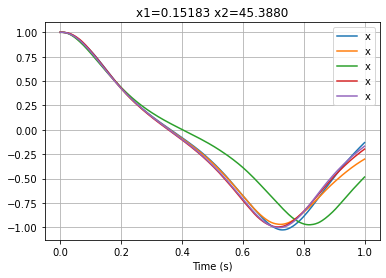

In [4]:
#Uniform random initialization for 3500 data points
ns = 3500
t0 = 0
tn = 1
ts = (tn-t0)*1000

#Uniform random initialization for ns data points
c=np.random.uniform(0.1,.5,ns)
k=np.random.uniform(5,50,ns)
print(c[2])

#Standard Deviation for c and k
std_c = np.std(c)
std_k = np.std(k)

#Time discretization domain
t = np.linspace(t0,tn,ts)
dt = t[2]-t[1]

#Initialising output matrices
X = np.zeros([ns,ts])
X_dot = np.zeros([ns,ts])

#Initialising parameters matrix
prm =np.zeros([ns,2]) 
for i in range(ns):
    #z=np.random.randn(100)
    if i%50 == 0:
        p1 = c[i]
        p2 = k[i]
    param = [p1,p2]
    X[i,:],X_dot[i,:] = Euler_Maruyama(param,dt,ts)
    prm[i] = param
print(X.shape)
print("prm",prm.shape)

#plot output
plt.figure(1)
plt.plot(t, X[1,:], label='x')
plt.plot(t, X[2,:], label='x')
plt.plot(t, X[3,:], label='x')
plt.plot(t, X[4,:], label='x')
plt.plot(t, X[5,:], label='x')
#plt.plot(t, X_dot[10,:], label='x_dot')
txt = "x1="+str(prm[5,0])[0:7]+" x2=" + str(prm[5,1])[0:7]
plt.title(label=txt)
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

[ 0.15183533 45.38802468]


<AxesSubplot:ylabel='Density'>

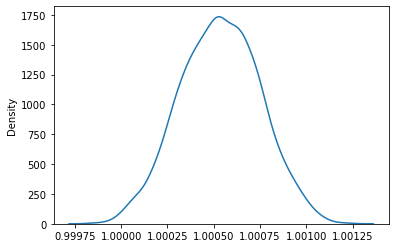

In [5]:
#Pdf plot of generated data at a particular time step
Y_at_t = X[:,5]
print(prm[0])
sns.kdeplot(Y_at_t)

In [6]:
#Preparing training dataset and dataloader
train_data = torch.from_numpy(X[0:2000,:]).to(device)
train_prm  = torch.from_numpy(prm[0:2000,:]).to(device)

Train_data = TensorDataset(train_data,train_prm)
Train_dl = DataLoader(Train_data, batch_size=50, shuffle=False)# We didn’t shuffle the data

 Deep Neural network for proposed model

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # function for stochastic term
        self.fA1 = nn.Sequential(nn.Linear(14, 64),
                                 nn.ELU(),
                                 nn.Linear(64 ,256),
                                 nn.ELU(),
                                 nn.Linear(256,512),
                                 nn.ELU(),
                                 nn.Linear(512,1024),
                                 nn.ELU(),
                                 nn.Linear(1024,512),
                                 nn.ELU(),
                                 nn.Linear(512,256),
                                 nn.ELU(),
                                 nn.Linear(256, 64),
                                 nn.ELU(),
                                 nn.Linear(64,1))


    def forward(self, batch_size, params,n):
        zp = params
        #Initializing the solution matrix and setting initial condition for displacement and velocity
        s_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
        s_dash[:,0] = x_in*torch.ones(batch_size).to(device)
        s_dash_dot = torch.zeros((batch_size,n),dtype = float).to(device) 
        s_dash_dot[:,0] = x_dot_in*torch.ones(batch_size).to(device)
        
        #Loop for time marching
        for i in range(n-1):
            s = torch.reshape(s_dash[:,i],(batch_size,1))
            s_dot = torch.reshape(s_dash_dot[:,i],(batch_size,1))
            
            # Taking sample for Z(random variable) from standard gaussian distribution
            z_A1 = torch.randn(batch_size,10).to(device)
            
            #Taking out 1st column out from the parameters i.e p1 and calling it z_p0
            z_p0 = torch.reshape(zp[:,0],(batch_size,1))
            
            #Taking out 2nd column out from the parameters i.e p2 and calling it z_p1
            z_p1 = torch.reshape(zp[:,1],(batch_size,1))
            
            #Input to the Neural network that will fill in for the unknown part
            input_fA1 = torch.cat((z_A1,z_p0,z_p1,s,s_dot),1).to(device)
            
            # Outputs from the neural networks
            fA1_loc = self.fA1(input_fA1)
            
             #Resize
            z_p1_ = torch.squeeze(z_p1)
            z_p0_ = torch.squeeze(z_p0)
            fA1_loc_ = torch.squeeze(fA1_loc)
            
            # Time as tensor  of size = batch size
            dT = dt * torch.ones(batch_size).to(device)
            
            # White noise as tensor of size = batch size
            dW =torch.sqrt(dT)* torch.randn(batch_size).to(device)
            
            # Using explicit Euler Maruyama to compute the output at (i+1)th step given the ith step output
            s_dash[:,i+1] = s_dash[:,i] + dT*s_dash_dot[:,i]
            s_dash_dot[:,i+1] = s_dash_dot[:,i] +  dT*(-z_p0_*s_dash_dot[:,i] + z_p1_*s_dash[:,i] + fA1_loc_ - alpha*(s_dash[:,i].clone())**3 + sigma*s_dash[:,i]*dW)
            
        s_hat =  s_dash
        s_hat_dot = s_dash_dot
        return s_hat, s_hat_dot, zp

Neural Network for purely data driven solver

In [8]:
class Datadriven(nn.Module):
    def __init__(self):
        super(Datadriven,self).__init__()
        self.network1 = nn.Sequential(nn.Linear(13, 64),
                                 nn.ELU(),
                                 nn.Linear(64 ,256),
                                 nn.ELU(),
                                 nn.Linear(256,512),
                                 nn.ELU(),
                                 nn.Linear(512,256),
                                 nn.ELU(),
                                 nn.Linear(256, 64),
                                 nn.ELU(),
                                 nn.Linear(64,1))
    
    def forward(self, batch_size, params,time):
        Z = torch.randn(batch_size,10).to(device)
        network_input = torch.cat((params,Z,time),1).to(device)
        output  = self.network1(network_input)
        out = torch.squeeze(output)
        return out

CMMD Loss Function

In [9]:
def gram_matrix(x, y, gamma1, pi1):
    sq_dist = torch.sum((torch.unsqueeze(x, 1)-torch.unsqueeze(y, 0))**2,2)      
    kernel = (pi1*torch.exp(-gamma1*sq_dist))
    return  kernel

In [10]:
def multidot(A,B,C,D):

  return torch.tensordot(A,torch.tensordot(B,torch.tensordot(C,D,dims=1),dims=1),dims=1)

In [11]:
def CMMD_loss(x_comp, x_hat, params, zp):
     
        gamma1 = torch.sigmoid(lambda1)
        #Mixture Coefficients   
        pi1 = torch.exp(beta1).to(device)
        #Gram Matrices
        k_d = gram_matrix(params, params, gamma1, pi1)
        #print('k_d',k_d.shape)
        k_s = gram_matrix(zp, zp, gamma1, pi1)
        #print('k_s',k_s)
        l_d = gram_matrix(x_comp, x_comp, gamma1, pi1)
        #print('l_d',l_d)
        l_s = gram_matrix(x_hat, x_hat, gamma1, pi1)
        #print('l_s',l_s)
        k_sd = gram_matrix(params,zp, gamma1, pi1)
        #print('k_sd',k_sd)
        l_ds = gram_matrix(x_comp, x_hat, gamma1, pi1)
        #print('l_ds',l_ds)
        lam = 2.0 #hyperparameteR
        row, col = k_d.shape
        k_d_tilda = k_d + (lam*torch.eye(row,col,device="cuda"))
        #print( 'k_d_tild',k_d_tilda)
        k_s_tilda = k_s + (lam*torch.eye(row,col,device="cuda"))
        #print(' k_s_tilda',k_s_tilda)
        k_sd_tilda = k_sd + (lam*torch.eye(row,col,device="cuda"))
        #print('k_sd_tilda',k_sd_tilda)
        loss = torch.sqrt(torch.trace(multidot(k_d,torch.inverse(k_d_tilda),l_d,torch.inverse(k_d_tilda))) + torch.trace(multidot(k_s,torch.inverse(k_s_tilda),l_s,torch.inverse(k_s_tilda))) - 2*torch.trace(multidot(k_sd,torch.inverse(k_d_tilda),l_ds,torch.inverse(k_s_tilda))))
        #print('shape',loss.shape)
        return loss 

Training function for the proposed model

In [12]:
def train_CMMD(model_dpc, epochs):
    opt = torch.optim.Adam(model_dpc.parameters(),lr = .00001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size =50, gamma=0.95, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=1
        b=1
        c=10
        i=0
        train_cum_loss = 0
        for batch,params in Train_dl:
           s = batch
           params = params[:,0:2]
           #print("params",params.shape)
           batch_size = s.shape[0]
           x1 = params[:,0] # since params is taking new set of values every iterations 
           #print("omega",omega.shape)
           x2 =  params[:,1]
           opt.zero_grad()
           s_hat,s_hat_dot,zp = model_dpc(batch_size=batch_size, params = params, n=1000)
           i=+1
           loss_CMMD = CMMD_loss(s, s_hat, params, params)
           loss_rec = ((s - s_hat)**2).sum()
           loss = a*loss_CMMD 
           train_cum_loss+=loss
           loss.backward()
           opt.step()
        scheduler.step()
        train_loss_epochs[epoch] = train_cum_loss/2000 ########bATCH_SIZE
        print("loss_CMMD",loss_CMMD)
        print("loss_rec",loss_rec)
    return model_dpc, train_loss_epochs,opt

Training with combined CMMD and MSE as loss function

In [13]:
def train_Comb(model_dpc, epochs):
    opt = torch.optim.Adam(model_dpc.parameters(),lr = .000001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size =500, gamma=0.99, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=100
        b=1
        c=10
        i=0
        train_cum_loss = 0
        for batch,params in Train_dl:
           s = batch
           params = params[:,0:2]
           #print("params",params.shape)
           batch_size = s.shape[0]
           x1 = params[:,0] # since params is taking new set of values every iterations 
           #print("omega",omega.shape)
           x2 =  params[:,1]
           opt.zero_grad()
           s_hat,s_hat_dot,zp = model_dpc(batch_size=batch_size, params = params, n=1000)
           i=+1
           loss_CMMD = CMMD_loss(s, s_hat, params, params)
           loss_rec = ((s - s_hat)**2).sum()
           loss = a*loss_CMMD + b*loss_rec
           train_cum_loss+=loss
           loss.backward()
           opt.step()
        scheduler.step()
        train_loss_epochs[epoch] = train_cum_loss/2000 ########bATCH_SIZE
        print("loss_CMMD",loss_CMMD)
        print("loss_rec",loss_rec)
    return model_dpc, train_loss_epochs,opt

Test function for the proposed DPC model

In [18]:
def test1(model_dpc,n):
    x1=np.random.uniform(0.1,0.5,1500)
    x2=np.random.uniform(5,50,1500)
    t = np.linspace(0,1,1000)
    dt = t[2]-t[1]
    S = np.zeros([1500,n])
    S_dot = np.zeros([1500,n])
    prm_test =np.zeros([1500,2]) 
    for i in range(1500):
        q1 = x1[i]
        q2 = x2[i]
        param = [q1,q2]
        S[i,:],S_dot[i,:] = Euler_Maruyama(param,dt,n)
        prm_test[i] = param
    print(S.shape)
    print(prm_test.shape)
    test_data1 = torch.from_numpy(S).to(device) 
    test_prm1 = torch.from_numpy(prm_test).to(device)
    Test_data1 = TensorDataset(test_data1,test_prm1)
    Test_dl_1 = DataLoader(Test_data1, batch_size=50, shuffle=False)
    with torch.no_grad():  
        s_full =  torch.empty(1500,n)
        s_hat_full =  torch.empty(1500,n)
        parameters =  torch.empty(1500,2) 
        i=0
        for batch,p in Test_dl_1:
            s = batch
            #print("s_shape",s.shape)
            batch_size = s.shape[0]
            parameters[i*batch_size:(i+1)*batch_size,:] = p
            #print(batch_size)
            s_full[i*batch_size:(i+1)*batch_size,:] = s
            s_hat, s_hat_dot, zp = model_dpc(batch_size=batch_size, params = p, n=n)
            s_hat_full[i*batch_size:(i+1)*batch_size,:] = s_hat
            i+=1
        x_hat = s_hat_full.cpu()
        X_hat = x_hat.detach().numpy()
        x = s_full.cpu()
        X= x.detach().numpy()
        er = mae = np.absolute(np.subtract(X_hat, X)).mean() 

    return er,parameters,X_hat,X

Test function for the all the models combined i.e the DPC model, pure physics and pure data driven model

In [14]:
def test2(model_dpc, model, n):
    x1=np.random.uniform(0.1,0.5,1500)
    x2=np.random.uniform(5,50,1500)
    t = np.linspace(0,1,1000)
    dt = t[2]-t[1]
    S = np.zeros([1500,n])
    S_dot = np.zeros([1500,n])
    prm_test =np.zeros([1500,2]) 
    for i in range(1500):
        q1 = x1[i]
        q2 = x2[i]
        param = [q1,q2]
        S[i,:],S_dot[i,:] = Euler_Maruyama(param,dt,n)
        prm_test[i] = param
    print(S.shape)
    print(prm_test.shape)
    test_data1 = torch.from_numpy(S).to(device) 
    test_prm1 = torch.from_numpy(prm_test).to(device)
    Test_data1 = TensorDataset(test_data1,test_prm1)
    Test_dl_1 = DataLoader(Test_data1, batch_size=1500, shuffle=False)
    with torch.no_grad():  
        s_full =  torch.empty(1500,n)
        s_hat_full =  torch.empty(1500,n)
        s_hat_full_data = torch.empty(1500,n)
        s_hat_full_physics = torch.empty(1500,n)
        parameters =  torch.empty(1500,2) 
        i=0
    for batch,p in Test_dl_1:
        s = batch
        #print("s_shape",s.shape)
        batch_size = s.shape[0]
        parameters[i*batch_size:(i+1)*batch_size,:] = p
        #print(batch_size)
        s_full[i*batch_size:(i+1)*batch_size,:] = s
        s_hat, s_hat_dot, zp = model_dpc(batch_size=batch_size, params = p, n=n)
        for t in range(n):
            time = t*dt*torch.ones((batch_size,1), dtype = float).to(device)
            s_hat_full_data[:,t] = model(batch_size=batch_size, params = p, time = time)   
        s_hat_full[i*batch_size:(i+1)*batch_size,:] = s_hat
        s_hat_full_physics, s_hat_dot_full_physics = Physics_pure(p,batch_size, dt, n) 
        i+=1
    x_hat = s_hat_full.cpu()
    X_hat = x_hat.detach().numpy()
    x_hat_data = s_hat_full_data.cpu()
    X_hat_data = x_hat_data.detach().numpy()
    x_hat_physics = s_hat_full_physics.cpu()
    X_hat_physics = x_hat_physics.detach().numpy()
    x = s_full.cpu()
    X= x.detach().numpy()
    er = mae = np.absolute(np.subtract(X_hat, X)).mean() 

    return er, parameters, X_hat, X_hat_data, X_hat_physics, X

Main: Training of the proposed model till convergence is reached 

In [ ]:
# No of epochs for training
epochs = 750

# lambda1 and beta1 are the parameters in the kernel function used to define the CMMD loss funct
lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
beta1 = torch.tensor(4.0, requires_grad = True).to(device)

#Included in the training process
lambda1 = torch.nn.Parameter(lambda1)
beta1 = torch.nn.Parameter(beta1)
model_dpc = DNN().to(device)
model_dpc.register_parameter('lanbda11',lambda1)
model_dpc.register_parameter('beta1',beta1)

#Training
model_dpc,train_loss_epochs,opt= train_CMMD(model_dpc.double(),epochs)

#plotting training loss vs number of epochs at the end of the training
epochs_array = np.linspace(0,epochs,epochs)
train_loss_epochs= train_loss_epochs.cpu()
train_loss_epochs= train_loss_epochs.detach().numpy()
fig1=plt.figure(1)
plt.plot(epochs_array ,train_loss_epochs, label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

In [ ]:
torch.save(amodel_dpc.state_dict(), 'PIDecoder_DVP_2_2k_Pdrift_updated3_alpha')

(1500, 10000)
(1500, 2)
X_hat (10000,)
X_hat (10000,)


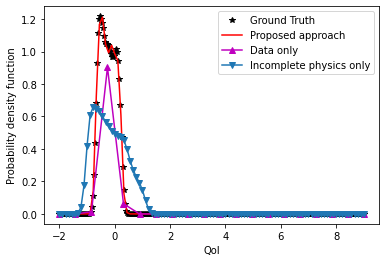

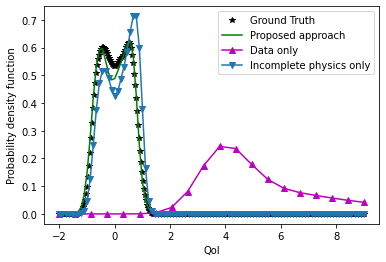

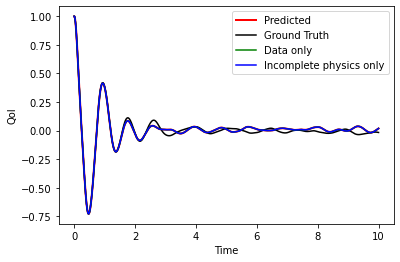

In [16]:
with torch.no_grad():  
    device = torch.device("cuda")
    lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
    beta1 = torch.tensor(4.0, requires_grad = True).to(device)
    lambda1 = torch.nn.Parameter(lambda1)
    beta1 = torch.nn.Parameter(beta1)
    model_dpc = DNN().to(device)
    model_dpc.register_parameter('lanbda11',lambda1)
    model_dpc.register_parameter('beta1',beta1)
    model_dpc.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdrift_updated3_alpha'))
    model_dpc.to(device)
    model = Datadriven().to(device)
    model.register_parameter('lanbda11',lambda1)
    model.register_parameter('beta1',beta1) 
    model.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdiffusion_data2'))
    nt =10000
    mae,prm, X_hat, X_hat_data, X_hat_physics, X = test2(model_dpc.double(), model.double(), n=nt) 
    prm = prm.cpu()
    prm = prm.detach().numpy()
    
    from scipy.stats import gaussian_kde
    density = gaussian_kde(X[:,300])
    density_1 = gaussian_kde(X_hat[:,300] )
    density_2 = gaussian_kde( X_hat_data[:,300])
    density_3 = gaussian_kde(X_hat_physics[:,300])
    
    density_p = gaussian_kde(X[:,8865])
    density_p_1 = gaussian_kde(X_hat[:,8865] )
    density_p_2 = gaussian_kde( X_hat_data[:,8865])
    density_p_3 = gaussian_kde(X_hat_physics[:, 8865])
    
  
    xs = np.linspace(-2,9,100)
    ys = np.linspace(-2,9,20)
    zs = np.linspace(-2,9,300)
    
    plt.figure(1) 
    plt.plot(zs,density(zs),"*",color ="k", label = "Ground Truth")
    plt.plot(xs,density_1(xs),"r", label = "Proposed approach")
    plt.plot(ys,density_2(ys),"-^",color ="m",label = "Data only")
    plt.plot(xs,density_3(xs),"-v",label = "Incomplete physics only")
    plt.ylabel('Probability density function')
    plt.xlabel('QoI')
    plt.legend()
    plt.savefig('n_multi_PI_DVP_PDrift.pdf')
    
    plt.figure(2) 
    plt.plot(zs,density_p(zs),"*",color ="k", label = "Ground Truth")
    plt.plot(xs,density_p_1(xs),"g", label = "Proposed approach")
    plt.plot(ys,density_p_2(ys),"-^",color ="m",label = "Data only")
    plt.plot(xs,density_p_3(xs),"-v",label = "Incomplete physics only")
    plt.ylabel('Probability density function')
    plt.xlabel('QoI')
    plt.legend()
    plt.savefig('n_multi_PI_DVP_PDrift_pred.pdf')
    
    t1 = np.linspace(0,10,nt)
    Xhat_mean = np.mean(X_hat,axis = 0)
    print('X_hat',Xhat_mean.shape)
    X_mean = np.mean(X,axis = 0)
    print('X_hat',X_mean.shape)
    
    plt.figure(3) 
    plt.plot(t1, Xhat_mean, color ="r", label='Predicted', linewidth =2.0) 
    plt.plot(t1, X_mean,color ="k", label='Ground Truth')
    plt.plot(t1, Xhat_mean, color ="g", label='Data only') 
    plt.plot(t1, Xhat_mean, color ="b", label='Incomplete physics only') 
    plt.xlabel('Time')
    plt.ylabel('QoI')
    plt.legend()
    plt.savefig('n_multi_PI_DVP_PDrift_Smean.pdf')

Hellinger distance

In [17]:
def Hellinger(pdf1,pdf2):
    output =np.sum(np.power(np.sqrt(pdf1)-np.sqrt(pdf2),2))
    return output

In [21]:
for k in range(5):
    er_dpc_mean = np.zeros(5)
    er_pd_mean = np.zeros(5)
    er_pp_mean= np.zeros(5)
    from scipy.stats import gaussian_kde
    with torch.no_grad():  
        device = torch.device("cuda")
        lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
        beta1 = torch.tensor(4.0, requires_grad = True).to(device)
        lambda1 = torch.nn.Parameter(lambda1)
        beta1 = torch.nn.Parameter(beta1)
        model_dpc = DNN().to(device)
        model_dpc.register_parameter('lanbda11',lambda1)
        model_dpc.register_parameter('beta1',beta1)
        model_dpc.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdrift_updated3_alpha'))
        model_dpc.to(device)
        model = Datadriven().to(device)
        model.register_parameter('lanbda11',lambda1)
        model.register_parameter('beta1',beta1) 
        model.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdiffusion_data2'))

        nt =10000
        x = np.linspace(-10,10,350)
        y = np.linspace(-10,10,350)
        z = np.linspace(-10,10,350)
        p = np.linspace(-10,10,350)
        er_dpc=np.zeros([nt])
        er_pd=np.zeros([nt])
        er_pp=np.zeros([nt])
        mae,prm, X_hat, X_hat_data, X_hat_physics, X=test2(model_dpc.double(), model.double(), n=nt)
        for i in range(1,nt):
            density = gaussian_kde(X[:,i])
            density_DPC = gaussian_kde(X_hat[:,i])
            density_PD = gaussian_kde(X_hat_data[:,i])
            density_PP = gaussian_kde(X_hat_physics[:,i])
            er_dpc[i] = Hellinger(density(x),density_DPC(y))
            er_pd[i] = Hellinger(density(x),density_PD(z))
            er_pp[i] = Hellinger(density(x),density_PP(p))

        er_dpc_mean[k] = np.mean(er_dpc)
        er_pd_mean[k] = np.mean(er_pd)
        er_pp_mean[k] = np.mean(er_pp)
        print("dpc",er_dpc_mean)
        print("pd",er_pd_mean)
        print("pp",er_pp_mean)
Error_dpc =  np.mean(er_dpc_mean)

(1500, 10000)
(1500, 2)


KeyboardInterrupt: 

In [22]:
er_dpc_mean = np.zeros(5)
er_pd_mean = np.zeros(5)
er_pp_mean= np.zeros(5)
for k in range(5):
    from scipy.stats import gaussian_kde
    with torch.no_grad():  
        device = torch.device("cuda")
        lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
        beta1 = torch.tensor(4.0, requires_grad = True).to(device)
        lambda1 = torch.nn.Parameter(lambda1)
        beta1 = torch.nn.Parameter(beta1)
        model_dpc = Decoder().to(device)
        model_dpc.register_parameter('lanbda11',lambda1)
        model_dpc.register_parameter('beta1',beta1)
        model_dpc.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdrift_updated3_alpha'))
        model_dpc.to(device)
        model = Datadriven().to(device)
        model.register_parameter('lanbda11',lambda1)
        model.register_parameter('beta1',beta1) 
        model.load_state_dict(torch.load('PIDecoder_DVP_2_2k_Pdiffusion_data2'))

        nt =10000
        x = np.linspace(-10,10,350)
        y = np.linspace(-10,10,350)
        z = np.linspace(-10,10,350)
        p = np.linspace(-10,10,350)
        er_dpc=np.zeros([nt])
        er_pd=np.zeros([nt])
        er_pp=np.zeros([nt])
        mae,prm, X_hat, X_hat_data, X_hat_physics, X=test2(model_dpc.double(), model.double(), n=nt)
        for i in range(1,nt):
            density = gaussian_kde(X[:,i])
            density_DPC = gaussian_kde(X_hat[:,i])
            density_PD = gaussian_kde(X_hat_data[:,i])
            density_PP = gaussian_kde(X_hat_physics[:,i])
            er_dpc[i] = Hellinger(density(x),density_DPC(y))
            er_pd[i] = Hellinger(density(x),density_PD(z))
            er_pp[i] = Hellinger(density(x),density_PP(p))

        er_dpc_mean[k] = np.mean(er_dpc)
        er_pd_mean[k] = np.mean(er_pd)
        er_pp_mean[k] = np.mean(er_pp)
        print("dpc",er_dpc_mean)
        print("pd",er_pd_mean)
        print("pp",er_pp_mean)
Error_dpc =  np.mean(er_dpc_mean)
Error_pd =  np.mean(er_pd_mean)
Error_pp =  np.mean(er_pp_mean)

print("Error_dpc",Error_dpc)
print("Error_dpc",Error_pd)
print("Error_dpc",Error_pp)

(1500, 10000)
(1500, 2)
dpc [0.04754843 0.         0.         0.         0.        ]
pd [23.84448452  0.          0.          0.          0.        ]
pp [1.34756953 0.         0.         0.         0.        ]
(1500, 10000)
(1500, 2)
dpc [0.04754843 0.04155596 0.         0.         0.        ]
pd [23.84448452 23.83150149  0.          0.          0.        ]
pp [1.34756953 1.33357071 0.         0.         0.        ]
(1500, 10000)
(1500, 2)
dpc [0.04754843 0.04155596 0.04119992 0.         0.        ]
pd [23.84448452 23.83150149 23.84819548  0.          0.        ]
pp [1.34756953 1.33357071 1.23936656 0.         0.        ]
(1500, 10000)
(1500, 2)
dpc [0.04754843 0.04155596 0.04119992 0.043475   0.        ]
pd [23.84448452 23.83150149 23.84819548 23.77390579  0.        ]
pp [1.34756953 1.33357071 1.23936656 1.30255374 0.        ]
(1500, 10000)
(1500, 2)
dpc [0.04754843 0.04155596 0.04119992 0.043475   0.04054976]
pd [23.84448452 23.83150149 23.84819548 23.77390579 23.75465757]
pp [1.3475